# **Vehicle Detection on the Road** 


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

%matplotlib inline

/Users/SandeepGangundi/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def image_color_convert(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)
    return feature_image
    
def extract_features(imgs, cspace='RGB', hog_cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #image = image.astype(np.float32)*255
        # apply color conversion if other than 'RGB'
        feature_image = image_color_convert(image, cspace)           
        hog_feature_image = image_color_convert(image, hog_cspace)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_feature_image.shape[2]):
                hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        #features.append(np.concatenate((hist_features, hog_features)))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, cspace='RGB', hog_cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    #1) Define an empty list to receive features
    features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = image_color_convert(image, cspace)           
    hog_feature_image = image_color_convert(image, hog_cspace)   
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(hog_feature_image.shape[2]):
            hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    #features.append(np.concatenate((hist_features, hog_features)))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', hog_color_space='HSV',
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, hog_cspace=hog_color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def search_windows_faster(image, windows, clf, scaler, color_space='RGB', hog_color_space='HSV',
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    feature_image = image_color_convert(image, color_space)           
    hog_feature_image = image_color_convert(image, hog_color_space)
    
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, hog_cspace=hog_color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def jpg_to_png(image):
    return image.astype(np.float32)/255

def get_windows_list(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_overlap=(0.5, 0.5), win_sizes=[64]):
    final_windows = []
    for win_size in win_sizes:
        #print("current window size: ", win_size)
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(win_size, win_size), xy_overlap=xy_overlap)
        final_windows = final_windows + windows
    #print("Total windows: ",len(final_windows))
    return final_windows

def get_labeled_image(image, hot_windows):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap

def get_labeled_image_new(image, windows):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for i in range(len(windows)):
        heat = add_heat(heat,windows[i])
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap
        

In [3]:
##########################################
# Split train and test in each dir       #
# to avoid similar data between training #
# and test set                           #
##########################################

cars_dir = '/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/vehicles/'
cars_train = []
cars_test = []
for dir in os.listdir(cars_dir):
    regex = cars_dir + "/" + dir + "/*png"
    cars_tmp = glob.glob(regex)
    split_index = int(len(cars_tmp)*0.8)
    tmp_train = cars_tmp[0:split_index]
    tmp_test = cars_tmp[split_index:len(cars_tmp)]
    cars_train = cars_train + tmp_train
    cars_test = cars_test + tmp_test

notcars_dir = '/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/non-vehicles/'
notcars_train = []
notcars_test = []
for dir in os.listdir(notcars_dir):
    regex = notcars_dir + "/" + dir + "/*png"
    notcars_tmp = glob.glob(regex)
    split_index = int(len(notcars_tmp)*0.8)
    tmp_train = notcars_tmp[0:split_index]
    tmp_test = notcars_tmp[split_index:len(notcars_tmp)]
    notcars_train = notcars_train + tmp_train
    notcars_test = notcars_test + tmp_test

train_imgs = cars_train + notcars_train
test_imgs = cars_test + notcars_test
print("Total training images:\t", len(train_imgs))
print("Total test images:\t", len(test_imgs))


Total training images:	 14206
Total test images:	 3554


In [4]:
#################
# Set Variables #
#################

spatial = 32
histbin = 64
colorspace = 'HSV'
hog_colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
xy_overlap = (0.65, 0.65)
y_start_stop = [400, 656]
win_sizes = [64,96,128]

In [5]:
####################
# Extract features #
####################

t=time.time()
train_car_features = extract_features(cars_train, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
train_notcar_features = extract_features(notcars_train, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

test_car_features = extract_features(cars_test, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
test_notcar_features = extract_features(notcars_test, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

45.83 Seconds to extract features...


In [6]:
##############
# get scaler #
##############
X = np.vstack((train_car_features, train_notcar_features, test_car_features, test_notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)

In [7]:
#########################
# Get training features #
#########################

X = np.vstack((train_car_features, train_notcar_features)).astype(np.float64)
X_train = X_scaler.transform(X)
y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcar_features))))
# shuffle to mix car and notcar features
X_train, y_train = shuffle(X_train, y_train)
print("Total training size:\t", len(X_train))

#####################
# Get test features #
#####################

X = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)
X_test = X_scaler.transform(X)
y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))
# shuffle to mix car and notcar features
X_test, y_test = shuffle(X_test, y_test)
print("Total test size:\t", len(X_test))


Total training size:	 14206
Total test size:	 3554


In [8]:
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

################################
# Use Random Forest Classifier #
################################

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=2)
t=time.time()
clf = clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train RFC...')
# Check the score of the RFC
print('Test Accuracy of RFC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My RFC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RFC')

Using spatial binning of: 32 and 64 histogram bins
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5028
12.8 Seconds to train RFC...
Test Accuracy of RFC =  0.9544
My RFC predicts:  [ 1.  1.  0.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  1.  1.  0.  1.]
0.00313 Seconds to predict 10 labels with RFC


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

# of windows:  373


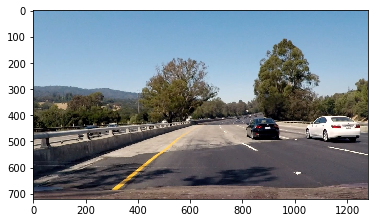

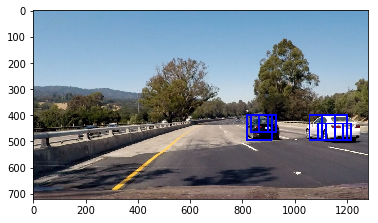

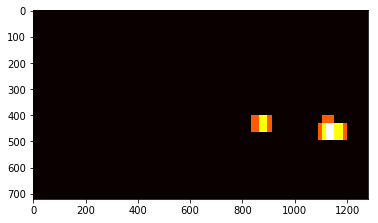

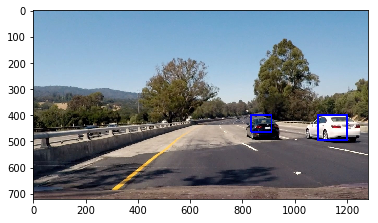

In [64]:
xy_overlap = (0.5, 0.5)
win_sizes = [64, 96]
image = mpimg.imread('test4.jpg')
plt.figure(); plt.imshow(image)
draw_image = np.copy(image)

windows = []
image_png = jpg_to_png(image)
final_windows = get_windows_list(image_png, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_overlap=xy_overlap, win_sizes=win_sizes)
windows.append(final_windows)
print("# of windows: ", len(final_windows))
hot_windows = search_windows(image_png, final_windows, clf, X_scaler, color_space=colorspace, 
                        hog_color_space=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel) 
windows.append(hot_windows)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.figure(); plt.imshow(window_img)
labeled_img, heatmap = get_labeled_image(image, hot_windows)
plt.figure(); plt.imshow(heatmap, cmap='hot')
plt.figure(); plt.imshow(labeled_img)


In [44]:
print(len(windows))
for i in range(len(windows)):
    print(len(windows[i]))

3
1
1


[((768, 400), (864, 496))]

In [68]:
#########################################
# Create pipeline for processing videos #
#########################################

windows = []

def process_image(image):
    global windows
    #global y_start_stop, xy_overlap
    image_png = jpg_to_png(image)
    final_windows = get_windows_list(image_png, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_overlap=xy_overlap, win_sizes=win_sizes)
    hot_windows = search_windows(image_png, final_windows, clf, X_scaler, color_space=colorspace, 
                        hog_color_space=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    if (len(windows) < 8):
        windows.append(hot_windows)
    elif (len(windows) == 8):
        windows.pop(0)
        windows.append(hot_windows)
    labeled_img, heatmap = get_labeled_image_new(image, windows)
    return labeled_img

1.09115 Seconds to process image with RFC


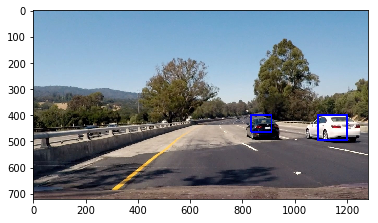

In [35]:
#################
# Test pipeline #
#################
image = mpimg.imread('test4.jpg')
t=time.time()
labeled_img = process_image(image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to process image with RFC')
plt.figure(); plt.imshow(labeled_img)


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos



In [58]:
import moviepy

In [59]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [60]:
moviepy.__version__

'0.2.2.13'

In [69]:
windows = []
xy_overlap = (0.75, 0.75)
win_sizes = [64, 96, 112]

white_output = '/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/project_video_output.mp4'
clip1 = VideoFileClip("/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/project_video.mp4")
#print(clip1.get_frame(0).shape)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<class 'moviepy.video.io.VideoFileClip.VideoFileClip'>
[MoviePy] >>>> Building video /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/project_video_output.mp4
[MoviePy] Writing video /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/project_video_output.mp4


100%|█████████▉| 1260/1261 [1:30:25<00:04,  4.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/project_video_output.mp4 

CPU times: user 1h 29min 52s, sys: 29 s, total: 1h 30min 21s
Wall time: 1h 30min 26s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 51.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.3 s, sys: 2.71 s, total: 15 s
Wall time: 13.7 s


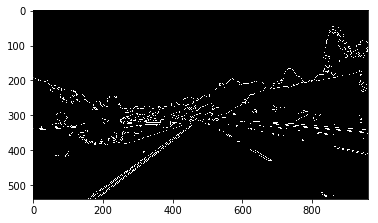

In [35]:
last_frame_left = None
last_frame_right = None

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Lane Detection Pipeline:
- First I converted the image to grayscale and added Gaussian blur to the image.
- Then I found edges in the image, by using canny edge detection. Worked trying out few min/max parameters for canny and found 50/150 to be a good choice.
- Since we are interested in only the lanes, we need to filter our that particular region by masking out the image. So I masked out only the lanes.
- After masking, I calucated Hough transform of the image to find out long continuous lines of the lanes and ignore all other lines in the image.
- Until here we have the lines of lanes that we are interested, so finally just merge these lines with the original image by adding both together with appropriate weights.
- Finally save the image.

For images, it was challenging to save the image using cv2 because the default image color depth was BGR and cv2.write expects RGB while saving, so I had to figure out a way to do that and finally use below code:

cv2.imwrite(new_file, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

For videos however I did not have to do this conversion and BGR color depth worked fine.

Future work:
I think right now in video mode, the lane lines detected flicker between the frames. I can enhance this to ignore small changes in the lines to avoid flickering.
For optional challenge, first obstacle was getting the masked region right, so I had to calculate coordinates of the region relative to the image size. The second obstable I am facing right now is during calculating Hough Transform. I need to ignore the horizontal lines and consider only the slant ones, I will try working on it but meanwhile would want to go ahead and submit this project.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 19.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 18.1 s, sys: 4.47 s, total: 22.6 s
Wall time: 14 s


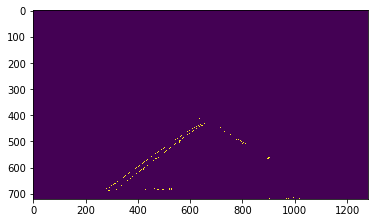

In [37]:
last_frame_left = None
last_frame_right = None

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_new)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))